# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

## Importing librairies 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
import warnings
from sklearn.svm import SVC, SVR
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  average_precision_score
import matplotlib.patches as patches
from sklearn import preprocessing
from scipy.fftpack import fft, ifft
from skimage.feature import hog

C:\Users\Hedi Fendri\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os
from PIL import Image, ImageDraw
import math
import cv2 
import xml.etree.ElementTree as ET
from skimage import feature
from skimage import transform
from skimage import measure

## Defining paths to dataset

In [4]:
src_path_train = './project-data/images/train/'
xml_path_train="./project-data/annotations/train/"
prepared_data_path="./project-data/images/train/prepared_data/"
img_list_dir = os.listdir(src_path_train)
img_list = [names for names in img_list_dir if names.endswith(".jpg")]
img_list_size = len(img_list)

src_path_test = './project-data/images/test/'
xml_path_test="./project-data/annotations/test/"
prepared_data_path_test="./project-data/images/test/prepared_data/"
img_list_dir_test = os.listdir(src_path_test)
img_list_test = [names for names in img_list_dir_test  if names.endswith(".jpg")]
img_list_size_test = len(img_list_test)

src_path_validation = './project-data/images/validation/'
xml_path_validation="./project-data/annotations/validation/"
prepared_data_path_validation="./project-data/images/validation/prepared_data/"
img_list_dir_validation = os.listdir(src_path_validation)
img_list_validation = [names for names in img_list_dir_validation  if names.endswith(".jpg")]
img_list_size_validation = len(img_list_validation)
print("train image size {} , test image size {}, validation image size {}".format(img_list_size,img_list_size_test,img_list_size_validation))

train image size 799 , test image size 50, validation image size 150


## Parsing Xml files to save ground truths 

In [5]:
def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)
    return objects

In [6]:
annotations_xmls = [parse_file(os.path.join(xml_path_train, name[:-4]) + '.xml') for name in img_list]
annotations_xmls_test=[parse_file(os.path.join(xml_path_test, name[:-4]) + '.xml') for name in img_list_test]
annotations_xmls_validation=[parse_file(os.path.join(xml_path_validation, name[:-4]) + '.xml') for name in img_list_validation]

In [7]:
def calculate_IOU(bbox1, bbox2):
    #Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity
    
    #determine the (x, y)-coordinates of the intersection rectangle
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]
    
    
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1+w1, x2+w2)
    yB = min(y1+h1, y2+h2)
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA ) * max(0, yB - yA )
    
    # compute the area of both the prediction and ground-truth
    boxAArea = (w1 ) * (h1 )
    boxBArea = (w2 ) * (h2 )

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou
def sliding_window(image, stepSize, windowSize):
    """
    This function perform sliding_window on the image whith a corresponding stepsize 
    ---------------------------------------------------------
    Inputs: 
        image 
        stepSize : the desired step between two images : (<48 = overlap) (>48 : no overlap)
        WindowSize: for our case should be : (48,48)
    Outputs :
        None     
    """
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")
def plot_predictedVsGround(im,ground_truth,predicted_varroa):
    """"
    This function plot the ground_truth Vs predicted_Varroas as rectangles 
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        im: numpy array of the image where to plot the rectangles : this can be the input original binary image 
        ground_truth : list of ground truth varroas rectangles 
        predicted_varroas : list of predicted_varroas rectangles
    -------------------------------------------------------------------------------------------------------
    return : 
       NONE
    """     

    fig,ax = plt.subplots(figsize=((7,7)))
    ax.set_title("Ground truth varroas vs predicted varroas")
    ax.imshow(im)
    green_rect=[]
    red_rect=[]
    for i in range(len(predicted_varroa)):
        green_rect=patches.Rectangle((predicted_varroa[i][0],predicted_varroa[i][1]),predicted_varroa[i][2],predicted_varroa[i][3],facecolor='none',linewidth=1,edgecolor='g',label='Predicted varroas') 

        ax.add_patch(green_rect)
    for box in ground_truth: 
        red_rect = patches.Rectangle((box[0], box[1]), box[2], box[3],
                                 linewidth=1,edgecolor='r',facecolor='none',label='Ground trurh')
        ax.add_patch(red_rect)
        ax.legend(handles=[red_rect,green_rect])
        
def compute_f1(boxes_found,ground_truth,screen=0):
    """
    Calculate the F_measure on the predicted box and the ground truth on a threshold from 0.1 to 0.5 
    --------------
    Inputs : 
        boxes_found : predicted box (e.g: [x,y,w,h]) 
        ground_truh: 
        screen: O: print  results 1: Withou printing results 
    """
    f_measure=[]

    for thresh in [0.1,0.2,0.3,0.4,0.5]:
        positive = 0
        f_neg=0
        for bf in boxes_found:
            for atb in ground_truth:
                iou = calculate_IOU(bf,atb)
                if iou > thresh:
                    positive+=1
        if positive>len(boxes_found):
            positive=len(boxes_found)
        for bf in ground_truth :
            iou=np.zeros((len(boxes_found),2))
            j=0
            for atb in boxes_found :
                iou[j]=calculate_IOU(bf,atb)
                j=j+1
            if (iou.sum()==0):
                f_neg+=1
        
        precision = 0.
        recall = 0.
        if len(boxes_found)>0:
            precision = positive/len(boxes_found)
        if (positive+f_neg)>0:
            recall = positive/(positive+f_neg)

        f1 = 0.
        if (precision+recall) > 0:
            f1 = 2*precision*recall/(precision+recall)

        if len(boxes_found) + len(ground_truth) == 0:
            f1 = 1
        if screen ==1: 
            print("TP with threshold {} =".format(thresh),positive)
            print("FP with threshold {} =".format(thresh),len(boxes_found)-positive)
            print("FN with threshold {} =".format(thresh),f_neg)
            print("F_measure for image with threshold={} =".format(thresh),f1)
        f_measure.append(f1)
    if screen==1:
        print("Mean F Measure =",np.mean(f_measure))
    return np.mean(f_measure)
def f1_measure(TP,FP,FN):
        precision = 0.
        recall = 0.
        if TP+FP>0:
            precision = positive/(TP+FP)
        if (TP+FN)>0:
            recall = positive/(TP+FN)

        f1 = 0.
        if (precision+recall) > 0:
            f1 = 2*precision*recall/(precision+recall)
        return f1
def compute_confusion_matrix(boxes_found,ground_truth,iou_threshold):
    """
    Calculate the F_measure on the predicted box and the ground truth on a threshold from 0.1 to 0.5 
    --------------
    Inputs : 
        boxes_found : predicted box (e.g: [x,y,w,h]) 
        ground_truh: 
        screen: O: print  results 1: Withou printing results 
    """

    positive = 0
    f_neg=0
    for bf in boxes_found:
        for atb in ground_truth:
            iou = calculate_IOU(bf,atb)
            if iou > iou_threshold:
                positive+=1
    if positive>len(boxes_found):
        positive=len(boxes_found)
    
    f_neg=len(ground_truth)-positive
    false_positive=len(boxes_found)-positive
    return (positive,false_positive,f_neg)

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

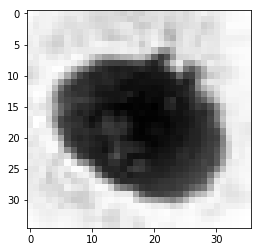

In [8]:
ref_im=cv2.imread("var_temp.jpg")
varroa_gray = cv2.cvtColor(ref_im, cv2.COLOR_BGR2GRAY)
varroa_gray=varroa_gray
plt.imshow(varroa_gray,cmap='gray')

In [9]:
def detect_by_segmentation(img,thres_corr):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    #grayscale
    #img_gray = rgb2gray(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #convolution with varroa
    #correlation = match_template(img_gray, varroa_gray)
    correlation = cv2.matchTemplate(img_gray, varroa_gray,cv2.TM_CCORR_NORMED)
    
    result = correlation > thres_corr
    
    #find objects
    labels = measure.label(result)
    props = measure.regionprops(labels)
    
    #get box for all objects
    boxes = []
    for prop in props:
        boxes.append([prop.bbox[1],prop.bbox[0],40,40])
    
    return boxes

In [10]:
def plot_boxes(image,boxes_1,boxes_2):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    for b in boxes_1:
        rect = patches.Rectangle((b[0], b[1]), b[2], b[3],linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    for b in boxes_2:
        rect = patches.Rectangle((b[0], b[1]), b[2], b[3],linewidth=2,edgecolor='g',facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [11]:
import skimage.io
import matplotlib.patches as patches
import numpy as np
import cv2

tot_true_pos = 0.
tot_found = 0.
tot_true = 0.

for x in range(img_list_size_test):
    #image = imread(src_path_test+img_list_test[x])
    image = cv2.imread(src_path_test+img_list_test[x])

    annotations_test_boxes = []
    L = len(annotations_xmls_test[x])
    for i in range(L):
        annotations_test_boxes.append(annotations_xmls_test[x][i]['bbox'])

    boxes_found = detect_by_segmentation(image,0.96)

    #plot_boxes(image,annotations_test_boxes,boxes_found)

    for bf in boxes_found:
        for atb in annotations_test_boxes:
            iou = calculate_IOU(bf,atb)
            if iou > 0.3:
                tot_true_pos+=1
    
    tot_found += len(boxes_found)
    tot_true += len(annotations_test_boxes)
       
    print('|',end='')

print('finished !')
precision = tot_true_pos/tot_found
recall = tot_true_pos/tot_true
f1 = 2*precision*recall/(precision+recall)
print(f1)

||||||||||||||||||||||||||||||||||||||||||||||||||finished !
0.2675324675324675


In [26]:
number=-1
F_measure=[]
for x in range(50):
    best_corr=0
    ground_truth_1=[]
    for i in range(len(annotations_xmls_test[x])): 
        ground_truth_1.append(annotations_xmls_test[x][i]['bbox'])
    number+=1
    #image = imread(src_path_test+img_list_test[x])
    image = cv2.imread(src_path_test+img_list_test[x])
    f1_old=0
    for cor in [0.5,0.6,0.7,0.8,0.9,1]:
        boxes_found = detect_by_segmentation(image,thres_corr=cor)
        f1=compute_f1(boxes_found,ground_truth_1,0)
        if f1>f1_old:
            best_corr=cor
            f1_old=f1
    boxes_found = detect_by_segmentation(image,thres_corr=best_corr)
    f1_final=compute_f1(boxes_found,ground_truth_1,0)
    #print("f1 measure for image {} is ".format(x),f1_final)
    F_measure.append(f1_final)
    #plot_predictedVsGround(image,ground_truth_1,boxes_found)
print("TOTAL MEAN F_MEASURE for each image seperately =",np.mean(F_measure))

TOTAL MEAN F_MEASURE for each image seperately = 0.4193420007089583


## Part 2: Implement your first detector


Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

#### Dataset preparation : Build the dataset (training, validation and testing )

Methods to build the dataset : 

In [12]:
import random
def split_and_label_v2(prepared_data_path,max_box_size,img,img_name,annotations):
    """
    This function allow us to take the region on interests from the training , validation and testing data : 
    Take a window of 48,48 of the varroas and one non varroa image selected from the remaining part of the image 
    randomly. 
    ------------------------------------
    Inputs :
        prepared_data_path : Path to save the result images 
        max_box_size: the maximum box sizes in the dataset 
        img : the image to be splitted 
        img_name : image name 
        annotations : Ground truth of the image (Varroas boxes)
    Outputs : 
        None
    """
    count=0
    width,height=img.shape[0],img.shape[1]
    
    for box in annotations: 
        name=img_name+"_"+str(count)+"_1"

        xmin,ymin,w,h=box[0],box[1],box[2],box[3] 
        max_size=int(max_box_size[0]/2)
        new_img_=img[max(0,ymin-10):min(ymin+max_size+10,width),max(0,xmin-10):min(xmin+max_size+10,height),:]
        im=Image.fromarray(new_img_)
        b, g, r = im.split()
        im= Image.merge("RGB", (r, g, b))
        im.save(prepared_data_path+name+".jpg") 
        #for i in range(2):
        name=img_name+"_"+str(count)+"_0"
        x1 = random.randint(0,height-48)
        y1 = random.randint(0,width-48)
        new_img=img[y1:min(y1+48,width),x1:min(height,x1+48),:]
        im=Image.fromarray(new_img)
        b, g, r = im.split()
        im= Image.merge("RGB", (r, g, b))
        im.save(prepared_data_path+name+".jpg") 
        count+=1
def make_dataset(img_list,src_path,max_box_size,prepared_data_path,annotations_xmls):
    """
    This function build the complete dataset for training , testing and validation 
    ---------------------------------------
    Inputs : 
        img_list : the list of images in the training or validation or testing 
        max_box_size : the maximum box size in the images 
        prepared_data_path : Path where to save the result images 
        annotations_xmls : The result of parsing the xml file 
    Outputs:
        None
    """
    for j in range(len(img_list)):
        name=img_list[j]
        img = cv2.imread(src_path+name)
        ground_truth_1=[]
        for i in range(len(annotations_xmls[j])): 
            ground_truth_1.append(annotations_xmls[j][i]['bbox'])
        ground_truth_1
        split_and_label_v2(prepared_data_path,max_box_size,img,name[:-4],ground_truth_1)

def resize(img_list_dir_prep,prepared_data_path):
    """
    This function allows to have the same dimension of the images and fixed to (48,48)
    ------------------------
    Inputs :
        img_list_dir_prep : image names of the images to be resized 
        prepared_data_path: Path where to save the resized images 
    Outputs : 
        None
    """
    img_list_prep = [names for names in img_list_dir_prep if names.endswith(".jpg")]
    sizes = [Image.open(prepared_data_path+f, 'r').size for f in img_list_prep]
    max_width,max_height=max(sizes)
    for item in img_list_dir_prep:
        if os.path.isfile(prepared_data_path+item):
            im = Image.open(prepared_data_path+item)
            
            f, e = os.path.splitext(prepared_data_path+item)
            imResize = im.resize((48,48), Image.ANTIALIAS)
            imResize.save(f + '.jpg', 'JPEG', quality=90)

In [13]:
def evaluate_method(y_true,y_pred): 
    """ Evaluating the model using f-measure and accuracy
     Parameters
    ----------
        y_true  : True labels

        y_pred  : Predicted labels
                    
    Returns : None
    
    """
    f1=metrics.f1_score(y_true, y_pred)
    acc=metrics.accuracy_score(y_true, y_pred)
    recall=metrics.recall_score(y_true, y_pred)
    precision=metrics.precision_score(y_true, y_pred)
    print("Recall= ",recall)
    print("precision= ",precision)
    print("F-measure= ",f1)
    print("Accuracy= ",acc)
    
def plot_roc(y_true,y_pred):
    """ Plotting Roc curve 
     Parameters
    ----------
        y_true  : True labels

        y_pred  : Predicted labels
                    
    Returns : None
    
    """
    auc=roc_auc_score(y_true, y_pred)
    print('auc=',auc)
    fpr,tpr,_=roc_curve(y_true, y_pred)
    plt.plot(fpr,tpr)

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    t=plt.title('Receiver operating characteristic')
    
def plot_prec_recall_curve(y_true, y_pred):
    precision, recall, thresholds=precision_recall_curve(y_true, y_pred)
    plt.plot(recall,precision)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    t=plt.title('Precision recall curve')
    print("AUPR= ",average_precision_score(y_true, y_pred))


After defining the methods let's build our dataset : <br> 
We already build the dataset : do not run the code again. 
You can ran the code after creating new folding in the corresponding (train , validation , test) folder (eg. folder named
prepared_data and pass the path to the function) Make dataset function will call the function split and label.

We define first in the cell bellow : the maximum varroas sizes for training , validation and testing : 

In [14]:
ground_truth_1=[]
for j in range(len(annotations_xmls)):
    for i in range(len(annotations_xmls[j])): 
        ground_truth_1.append(annotations_xmls[j][i]['bbox'][2:3])
max_box_size=max(ground_truth_1)
ground_truth_1=[]

for j in range(len(annotations_xmls_test)):
    for i in range(len(annotations_xmls_test[j])): 
        ground_truth_1.append(annotations_xmls_test[j][i]['bbox'][2:3])
max_box_size_test=max(ground_truth_1)

for j in range(len(annotations_xmls_validation)):
    for i in range(len(annotations_xmls_validation[j])): 
        ground_truth_1.append(annotations_xmls_validation[j][i]['bbox'][2:3])
max_box_size_validation=max(ground_truth_1)
print("train max box size {} , test max box size {}, validation max box size {}".format(max_box_size,max_box_size_test,max_box_size_validation))

train max box size [56] , test max box size [52], validation max box size [52]


In [15]:
"""
make_dataset(img_list,src_path_train,max_box_size,prepared_data_path,annotations_xmls)
make_dataset(img_list_test,src_path_test,max_box_size_test,prepared_data_path_test,annotations_xmls_test)
make_dataset(img_list_validation,src_path_validation,max_box_size_validation,prepared_data_path_validation,annotations_xmls_validation)
"""

'\nmake_dataset(img_list,src_path_train,max_box_size,prepared_data_path,annotations_xmls)\nmake_dataset(img_list_test,src_path_test,max_box_size_test,prepared_data_path_test,annotations_xmls_test)\nmake_dataset(img_list_validation,src_path_validation,max_box_size_validation,prepared_data_path_validation,annotations_xmls_validation)\n'

It's important to mention here that the dataset is build balanced in the very begining , We  train on the training and test on the testing dataset. Afterwords the detected False positive is added to the training dataset to end up with 36% of varroas and 64 % of non varroas. We repeated the process of training and adding the false positive 3 times

Here we will resize our images to the same size (48,48) : </br> 
We already resized the dataset , Please run the following code only one time 

In [16]:
img_list_dir_prep = os.listdir(prepared_data_path)
number_label_non_varroa_train=0
number_label_varroa_train=0
for prep_name in img_list_dir_prep: 
    if prep_name.endswith('_1.jpg'):
        number_label_varroa_train+=1
    if prep_name.endswith('_0.jpg'):
        number_label_non_varroa_train+=1
print("FOR TRAINING")
print("number of images with label =1 (varroas) is ",number_label_varroa_train)
print("number of images with label =0 (non varroas) is ",number_label_non_varroa_train)
print("Total number of files = ",number_label_varroa_train+number_label_non_varroa_train)    

img_list_dir_prep_test = os.listdir(prepared_data_path_test)
number_label_non_varroa_test=0
number_label_varroa_test=0
for prep_name in img_list_dir_prep_test: 
    if prep_name.endswith('_1.jpg'):
        number_label_varroa_test+=1
    if prep_name.endswith('_0.jpg'):
        number_label_non_varroa_test+=1
print("FOR TESTING")
print("number of images with label =1 (varroas) is ",number_label_varroa_test)
print("number of images with label =0 (non varroas) is ",number_label_non_varroa_test)
print("Total number of files = ",number_label_varroa_test+number_label_non_varroa_test)

img_list_dir_prep_validation = os.listdir(prepared_data_path_validation)
number_label_non_varroa_val=0
number_label_varroa_val=0
for prep_name in img_list_dir_prep_validation: 
    if prep_name.endswith('_1.jpg'):
        number_label_varroa_val+=1
    if prep_name.endswith('_0.jpg'):
        number_label_non_varroa_val+=1
print("FOR VALIDATION")
print("number of images with label =1 (varroas) is ",number_label_varroa_val)
print("number of images with label =0 (non varroas) is ",number_label_non_varroa_val)
print("Total number of files = ",number_label_varroa_val+number_label_non_varroa_val)
img_list_prep_train = [names for names in img_list_dir_prep if names.endswith(".jpg")]
img_list_prep_test = [names for names in img_list_dir_prep_test if names.endswith(".jpg")]
img_list_prep_validation = [names for names in img_list_dir_prep_validation if names.endswith(".jpg")]
num_imgs_train=number_label_varroa_train+number_label_non_varroa_train
num_imgs_test=number_label_varroa_test+number_label_non_varroa_test
num_imgs_validation=number_label_varroa_val+number_label_non_varroa_val

FOR TRAINING
number of images with label =1 (varroas) is  7493
number of images with label =0 (non varroas) is  12213
Total number of files =  19706
FOR TESTING
number of images with label =1 (varroas) is  582
number of images with label =0 (non varroas) is  582
Total number of files =  1164
FOR VALIDATION
number of images with label =1 (varroas) is  1539
number of images with label =0 (non varroas) is  1539
Total number of files =  3078


### Building the training feature space

In [17]:
X_train_simple=np.zeros((len(img_list_dir_prep),10))
kernelSize=4
kernel = np.ones((kernelSize,kernelSize))

for i in range(len(img_list_dir_prep)):
    name=img_list_dir_prep[i]
    #if i==0 : #print(name)
    img = cv2.imread(prepared_data_path+name)
    X_train_simple[i,7]=np.mean(img[:,:,0]/255)
    X_train_simple[i,8]=np.mean(img[:,:,1]/255) 
    X_train_simple[i,9]=np.mean(img[:,:,2]/255) 
    im= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X_train_simple[i,4]=np.max(cv2.matchTemplate(im,varroa_gray,cv2.TM_CCOEFF_NORMED))
    ret,thresh = cv2.threshold(im,100,255,cv2.THRESH_BINARY)    
    thresh[thresh>0]=1
    
    hough_res=transform.hough_circle(thresh,np.arange(6,8,1))
    accum,cx,cy,radii=transform.hough_circle_peaks(hough_res,np.arange(6,8,1),total_num_peaks=10)
    X_train_simple[i,5]=hough_res.mean()
    X_train_simple[i,6]=hough_res.std() 
    #if(np.sum(thresh>0)>2100):
    #    thresh=np.zeros_like(thresh)
    image_proprieties = measure.regionprops(thresh)
    for prop in image_proprieties: 
        X_train_simple[i,0]=np.max(prop.area)
        X_train_simple[i,1]=np.max(prop.perimeter)
        X_train_simple[i,2]=np.max(prop.perimeter**2/prop.area)
        X_train_simple[i,3]=np.max(prop.area/prop.bbox_area)

### Building the training feature space

In [18]:
X_test_simple=np.zeros((len(img_list_dir_prep_test),10))
kernelSize=4
kernel = np.ones((kernelSize,kernelSize))

for i in range(len(img_list_dir_prep_test)):
    name=img_list_dir_prep_test[i]
    #if i==0 : #print(name)
    img = cv2.imread(prepared_data_path_test+name)
    X_test_simple[i,7]=np.mean(img[:,:,0]/255)
    X_test_simple[i,8]=np.mean(img[:,:,1]/255) 
    X_test_simple[i,9]=np.mean(img[:,:,2]/255)
    im= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X_test_simple[i,4]=np.max(cv2.matchTemplate(im,varroa_gray,cv2.TM_CCOEFF_NORMED))

    ret,thresh = cv2.threshold(im,100,255,cv2.THRESH_BINARY)    
    thresh[thresh>0]=1  
    hough_res=transform.hough_circle(thresh,np.arange(6,8,1))
    accum,cx,cy,radii=transform.hough_circle_peaks(hough_res,np.arange(6,8,1),total_num_peaks=10)
    X_test_simple[i,5]=hough_res.mean()
    X_test_simple[i,6]=hough_res.std() 
    #if(np.sum(thresh>0)>2100):
    #   thresh=np.zeros_like(thresh)
 
    image_proprieties = measure.regionprops(thresh)
    for prop in image_proprieties: 
        X_test_simple[i,0]=np.max(prop.area)
        X_test_simple[i,1]=np.max(prop.perimeter)
        X_test_simple[i,2]=np.max(prop.perimeter**2/prop.area)
        X_test_simple[i,3]=np.max(prop.area/prop.bbox_area)


### Building the validation feature space

In [19]:
X_val_simple=np.zeros((len(img_list_prep_validation),10))
kernelSize=4
kernel = np.ones((kernelSize,kernelSize))

for i in range(len(img_list_prep_validation)):
    name=img_list_prep_validation[i]
    #if i==0 : #print(name)
    img = cv2.imread(prepared_data_path_validation+name)
    X_val_simple[i,7]=np.mean(img[:,:,0]/255)
    X_val_simple[i,8]=np.mean(img[:,:,1]/255) 
    X_val_simple[i,9]=np.mean(img[:,:,2]/255)
    im= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X_val_simple[i,4]=np.max(cv2.matchTemplate(im,varroa_gray,cv2.TM_CCOEFF_NORMED))

    ret,thresh = cv2.threshold(im,100,255,cv2.THRESH_BINARY)    
    thresh[thresh>0]=1  
    hough_res=transform.hough_circle(thresh,np.arange(6,8,1))
    accum,cx,cy,radii=transform.hough_circle_peaks(hough_res,np.arange(6,8,1),total_num_peaks=10)
    X_val_simple[i,5]=hough_res.mean()
    X_val_simple[i,6]=hough_res.std() 
    #if(np.sum(thresh>0)>2100):
    #   thresh=np.zeros_like(thresh)
 
    image_proprieties = measure.regionprops(thresh)
    for prop in image_proprieties: 
        X_val_simple[i,0]=np.max(prop.area)
        X_val_simple[i,1]=np.max(prop.perimeter)
        X_val_simple[i,2]=np.max(prop.perimeter**2/prop.area)
        X_val_simple[i,3]=np.max(prop.area/prop.bbox_area)

### Prepocessing: Normalizing the dataset 

Choose between two types of normalization : 
* Substracting the mean and dividing by the standard deviation
* Normalize in a range between 0 and 1

In [20]:
"""
X_train_simple = preprocessing.scale(X_train_simple)
X_test_simple=preprocessing.scale(X_test_simple)
X_val_simple=preprocessing.scale(X_val_simple)
"""

'\nX_train_simple = preprocessing.scale(X_train_simple)\nX_test_simple=preprocessing.scale(X_test_simple)\nX_val_simple=preprocessing.scale(X_val_simple)\n'

In [21]:
min_max_scaler = preprocessing.MinMaxScaler()
scaler = min_max_scaler.fit(X_train_simple)
X_train_simple = scaler.transform(X_train_simple)
X_test_simple = scaler.transform(X_test_simple)
X_val_simple = scaler.transform(X_val_simple)


### Building the label arrays

In [22]:
Y_train_simple=np.zeros((num_imgs_train,1))
for i in range(len(img_list_prep_train)):
    name=img_list_prep_train[i]
    if name.endswith("_1.jpg"):
        Y_train_simple[i,0]=1

Y_test_simple=np.zeros((num_imgs_test,1))
for i in range(len(img_list_prep_test)):
    name=img_list_prep_test[i]
    if name.endswith("_1.jpg"):
        Y_test_simple[i,0]=1

Y_val_simple=np.zeros((num_imgs_validation,1))
for i in range(len(img_list_prep_validation)):
    name=img_list_prep_validation[i]
    if name.endswith("_1.jpg"):
        Y_val_simple[i,0]=1

### Training and hyperparameter Tuning using  grid-search on validation data

In [401]:
from hypopt import GridSearch
Cs = [0.001, 0.01, 0.1, 1,10,50]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
warnings.filterwarnings('ignore')
opt = GridSearch(SVC(kernel='rbf'),param_grid)
opt.fit(X_train_simple, Y_train_simple, X_val_simple, Y_val_simple, scoring='f1')
print("Best parameters set found on development set:")
print()
print(opt.best_params)
print()
print("Grid scores on development set:")
print()
for param in (opt.param_scores):
    print(param)
print()
#print('Test Score for Optimized Parameters:', opt.score(X_test, y_test))

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01}

Grid scores on development set:

({'C': 10, 'gamma': 0.01}, 0.9376193507320177)
({'C': 0.1, 'gamma': 0.1}, 0.9361970941250789)
({'C': 50, 'gamma': 0.01}, 0.9361283982967573)
({'C': 1, 'gamma': 0.1}, 0.9360597208698475)
({'C': 50, 'gamma': 0.001}, 0.93539237314844)
({'C': 0.01, 'gamma': 1}, 0.9338471419396275)
({'C': 50, 'gamma': 1}, 0.9337329337329336)
({'C': 1, 'gamma': 0.01}, 0.9324111914492298)
({'C': 10, 'gamma': 0.001}, 0.9321608040201005)
({'C': 1, 'gamma': 0.001}, 0.9295418641390205)
({'C': 0.01, 'gamma': 0.1}, 0.9292482627921668)
({'C': 0.1, 'gamma': 0.01}, 0.9286616161616161)
({'C': 0.1, 'gamma': 1}, 0.9278830176138252)
({'C': 10, 'gamma': 1}, 0.9229202037351444)
({'C': 0.001, 'gamma': 1}, 0.9193857965451057)
({'C': 10, 'gamma': 0.1}, 0.9144220934197068)
({'C': 50, 'gamma': 0.1}, 0.9087779690189328)
({'C': 1, 'gamma': 1}, 0.9056994818652849)
({'C': 0.1, 'gamma': 0.001}, 0.0)
({'C': 0.01, 'gamma': 0.01}, 0

### Let's now see the model performance

#### First , the result on training data

In [24]:
model_svm=SVC(C=10, kernel='rbf', gamma=0.01)
model_svm.fit(X_train_simple, Y_train_simple.ravel())
y_pred_svm_content_train=model_svm.predict(X_train_simple)
evaluate_method(Y_train_simple.ravel(),y_pred_svm_content_train)

Recall=  0.9029761110369678
precision=  0.8654387311332822
F-measure=  0.8838090261903206
Accuracy=  0.9097229270273013


#### Now on testing

In [25]:
model_svm.fit(X_train_simple, Y_train_simple.ravel())
y_pred_svm_content_test=model_svm.predict(X_test_simple)
evaluate_method(Y_test_simple,y_pred_svm_content_test)

Recall=  0.8676975945017182
precision=  0.9692898272552783
F-measure=  0.915684496826836
Accuracy=  0.9201030927835051


We can deduce that there is not a risk of overfitting 

AUPR=  0.9072016542335319


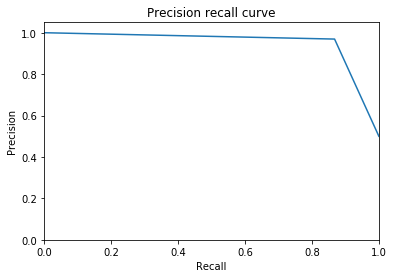

In [26]:
plot_prec_recall_curve(Y_test_simple,y_pred_svm_content_test)

auc= 0.9201030927835052


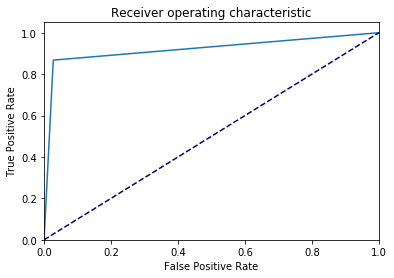

In [27]:
plot_roc(Y_test_simple,y_pred_svm_content_test)

As we can see , our model is robust with only 4 features but for only one object by image (after splitting). 
Let's see now if we can detect varroas on all the testing images without knowing the ground truth using sliding window-

### Test images as unseen (no ground_truth) : Sliding window 

In [28]:
stepSize=24
winW=48
winH=48
windowSize=(winW,winH)
f1_final=[]
h=[]
hedi=[]
X_unseen_simple=np.zeros((1,10))

for image_number in range(50):
    img_name=img_list_test[image_number]
    ID=img_name[:-4]
    im=cv2.imread(src_path_test+img_name)
    detections = []
    ground_truth_1=[]
    for i in range(len(annotations_xmls_test[image_number])): 
        ground_truth_1.append(annotations_xmls_test[image_number][i]['bbox'])
    for (x,y,window) in sliding_window(im, stepSize, windowSize=(winW,winH)):
            # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        img=(window)
        blue=np.mean(img[:,:,0]/255)
        green=np.mean(img[:,:,1]/255) 
        red=np.mean(img[:,:,2]/255)
        img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(img,100,255,cv2.THRESH_BINARY)  
        tempmatch=np.abs(np.max(cv2.matchTemplate(img,varroa_gray,cv2.TM_CCOEFF_NORMED)))
        h.append(tempmatch)
        thresh[thresh>0]=1 
        hough_res=transform.hough_circle(thresh,np.arange(6,8,1))
        accum,cx,cy,radii=transform.hough_circle_peaks(hough_res,np.arange(6,8,1),total_num_peaks=10)
        mean=hough_res.mean()
        standard=hough_res.std() 
        image_proprieties = measure.regionprops(thresh)
        for prop in image_proprieties: 
            area=np.max(prop.area)
            perimeter=np.max(prop.perimeter) 
            circularity=np.max(prop.perimeter**2/prop.area)
            rectangularity=np.max(prop.area/prop.bbox_area)
        X_unseen_simple[0,:]=[area,perimeter,circularity,rectangularity,tempmatch,mean,standard,blue,green,red]
       
        X_unseen_simple = scaler.transform(X_unseen_simple)
        #print(X_unseen_simple.sum())
        pred_unseen=model_svm.predict(X_unseen_simple)
        hedi.append(pred_unseen)
        if pred_unseen == 1:
            if model_svm.decision_function(X_unseen_simple) > 0.8:  
                detections.append((x , y, model_svm.decision_function(X_unseen_simple),windowSize[0],windowSize[1]))

    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
    sc = [score[0] for (x, y, score, w, h) in detections]
    #print("detection confidence score: ", sc)
    sc = np.array(sc)
    pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.1)
    if len(pick)!=0:
        pick[:,2]=48
        pick[:,3]=48
    if len(rects)!=0:
        rects[:,2]=48
        rects[:,3]=48
    f1=compute_f1(rects,ground_truth_1,0)
    print("f1 measure for image {} is ".format(image_number),f1)
    f1_final.append(f1)
print("MEAN F MEASURE" , np.mean(f1_final))

f1 measure for image 0 is  0.0
f1 measure for image 1 is  0.7287802810328069
f1 measure for image 2 is  0.0
f1 measure for image 3 is  0.8395604395604396
f1 measure for image 4 is  0.9714285714285713
f1 measure for image 5 is  0.0
f1 measure for image 6 is  0.2637144837144837
f1 measure for image 7 is  0.41025641025641024
f1 measure for image 8 is  0.3998850574712644
f1 measure for image 9 is  0.3407439242255705
f1 measure for image 10 is  0.6539787798408488
f1 measure for image 11 is  0.5030537634408603
f1 measure for image 12 is  0.0
f1 measure for image 13 is  0.491053146061635
f1 measure for image 14 is  0.08
f1 measure for image 15 is  0.13333333333333336
f1 measure for image 16 is  0.0
f1 measure for image 17 is  0.0
f1 measure for image 18 is  0.15103485104073766
f1 measure for image 19 is  0.22222222222222224
f1 measure for image 20 is  0.17605953726215343
f1 measure for image 21 is  0.1638095238095238
f1 measure for image 22 is  0.0
f1 measure for image 23 is  0.32761995457117

The function bellow take an image as input and give the precited varroas as output using sliding window on svm model: 

In [29]:
def detect_method_1(im,model_svm,overlap_thresh_nms,prob_thresh,stepSize):
    """
    This function takes as an imput and perform the model prediction using sliding windows 
    ---------------
    INPUTS : 
        im: image to predict 
        model_svm : SVM model used to predict the varroas 
        overlap_thresh : threshold for the non maximum supression algorithm 
        StepSize: Step size of the sliding window 
    OUTPUTS :
        pred_varroas : list with the predected varroas after passing through the non maximum supression algorithm
    """
    winW=48
    winH=48
    windowSize=(winW,winH)
    f1_final=[]

    X_unseen_simple=np.zeros((1,10))


    for (x,y,window) in sliding_window(im, stepSize, windowSize=(winW,winH)):
            # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        img=(window)
        blue=np.mean(img[:,:,0]/255)
        green=np.mean(img[:,:,1]/255) 
        red=np.mean(img[:,:,2]/255)
        img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(img,100,255,cv2.THRESH_BINARY)  
        tempmatch=np.abs(np.max(cv2.matchTemplate(img,varroa_gray,cv2.TM_CCOEFF_NORMED)))
        h.append(tempmatch)
        thresh[thresh>0]=1 
        hough_res=transform.hough_circle(thresh,np.arange(6,8,1))
        accum,cx,cy,radii=transform.hough_circle_peaks(hough_res,np.arange(6,8,1),total_num_peaks=10)
        mean=hough_res.mean()
        standard=hough_res.std() 
        image_proprieties = measure.regionprops(thresh)
        for prop in image_proprieties: 
            area=np.max(prop.area)
            perimeter=np.max(prop.perimeter) 
            circularity=np.max(prop.perimeter**2/prop.area)
            rectangularity=np.max(prop.area/prop.bbox_area)
        X_unseen_simple[0,:]=[area,perimeter,circularity,rectangularity,tempmatch,mean,standard,blue,green,red]

        X_unseen_simple = scaler.transform(X_unseen_simple)
        #print(X_unseen_simple.sum())
        pred_unseen=model_svm.predict(X_unseen_simple)
        hedi.append(pred_unseen)
        if pred_unseen == 1:
            if model_svm.decision_function(X_unseen_simple) > prob_thresh:  
                detections.append((x , y, model_svm.decision_function(X_unseen_simple),windowSize[0],windowSize[1]))

    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
    sc = [score[0] for (x, y, score, w, h) in detections]
    #print("detection confidence score: ", sc)
    sc = np.array(sc)
    pick = non_max_suppression(rects, probs = sc, overlapThresh = overlap_thresh_nms)
    if len(pick)!=0:
        pick[:,2]=48
        pick[:,3]=48
    if len(rects)!=0:
        rects[:,2]=48
        rects[:,3]=48
    predicted_varroas=pick
    
    return predicted_varroas


### SVM-HOG DETECTOR

In [30]:
X_train_simple_hog=np.zeros((len(img_list_dir_prep),1296))

for i in range(len(img_list_dir_prep)):
    name=img_list_dir_prep[i]
    #if i==0 : #print(name)
    img = cv2.imread(prepared_data_path+name)
    hog_feature=hog(img)
    hog_feature=hog_feature.reshape(1,-1)
    X_train_simple_hog[i]=hog_feature
    

C:\Users\Hedi Fendri\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [31]:
X_val_simple_hog=np.zeros((len(img_list_dir_prep_validation),1296))

for i in range(len(img_list_dir_prep_validation)):
    name=img_list_dir_prep_validation[i]
    #if i==0 : #print(name)
    img = cv2.imread(prepared_data_path_validation+name)
    hog_feature=hog(img)
    hog_feature=hog_feature.reshape(1,-1)
    X_val_simple_hog[i]=hog_feature
    

C:\Users\Hedi Fendri\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [32]:
X_test_simple_hog=np.zeros((len(img_list_prep_test),1296))
for i in range(len(img_list_prep_test)):
    name=img_list_dir_prep_test[i]
    #if i==0 : #print(name)
    img = cv2.imread(prepared_data_path_test+name)
    hog_feature=hog(img)
    hog_feature=hog_feature.reshape(1,-1)
    X_test_simple_hog[i]=hog_feature

C:\Users\Hedi Fendri\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [513]:
from hypopt import GridSearch
Cs = [0.001, 0.01, 0.1, 1,10,50]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
warnings.filterwarnings('ignore')
opt = GridSearch(SVC(kernel='rbf'),param_grid)
opt.fit(X_train_simple_hog, Y_train_simple, X_val_simple_hog, Y_val_simple, scoring='f1')
print("Best parameters set found on development set:")
print()
print(opt.best_params)
print()
print("Grid scores on development set:")
print()
for param in (opt.param_scores):
    print(param)
print()
#print('Test Score for Optimized Parameters:', opt.score(X_test, y_test))


Best parameters set found on development set:

{'C': 50, 'gamma': 1}

Grid scores on development set:

({'C': 50, 'gamma': 1}, 0.9539582643259358)
({'C': 10, 'gamma': 1}, 0.953519256308101)
({'C': 1, 'gamma': 1}, 0.9414141414141414)
({'C': 50, 'gamma': 0.1}, 0.9391187352842247)
({'C': 10, 'gamma': 0.1}, 0.9275756545392724)
({'C': 50, 'gamma': 0.01}, 0.9118457300275482)
({'C': 0.1, 'gamma': 1}, 0.8990182328190743)
({'C': 1, 'gamma': 0.1}, 0.893258426966292)
({'C': 10, 'gamma': 0.01}, 0.8920154766092155)
({'C': 50, 'gamma': 0.001}, 0.8707824838478105)
({'C': 0.1, 'gamma': 0.1}, 0.7975318164288469)
({'C': 1, 'gamma': 0.01}, 0.7956740054074932)
({'C': 10, 'gamma': 0.001}, 0.794276875483372)
({'C': 0.01, 'gamma': 1}, 0.7797408716136632)
({'C': 1, 'gamma': 0.001}, 0.43111337061515004)
({'C': 0.1, 'gamma': 0.01}, 0.4287169042769857)
({'C': 0.01, 'gamma': 0.1}, 0.37295298468040144)
({'C': 0.001, 'gamma': 1}, 0.0)
({'C': 0.001, 'gamma': 0.01}, 0.0)
({'C': 0.001, 'gamma': 0.1}, 0.0)
({'C': 0.1, 

Testing The SVM_based on HOG method : 

In [ ]:
model_svm=SVC(C=50, kernel='rbf', gamma=1)
model_svm.fit(X_train_simple_hog, Y_train_simple.ravel())
y_pred_svm_content_test_hog=model_svm.predict(X_test_simple_hog)
evaluate_method(Y_test_simple.ravel(),y_pred_svm_content_test_hog)

In [ ]:
stepSize=14
winW=48
winH=48
windowSize=(winW,winH)
f1_final=[]
jason_hog={}
jason_hog_nms={}
for image_number in range(50):
    img_name=img_list_test[image_number]
    ID=img_name[:-4]
    im=cv2.imread(src_path_test+img_name)
    detections = []
    ground_truth_1=[]
    for i in range(len(annotations_xmls_test[image_number])): 
        ground_truth_1.append(annotations_xmls_test[image_number][i]['bbox'])
    for (x,y,window) in sliding_window(im, stepSize, windowSize=(winW,winH)):
            # if the window does not meet our desired window size, ignore it!
            if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
                continue
            window=rgb2gray(window)
            fds = hog(window) # extract HOG features from the window captured
            fds = fds.reshape(1, -1) # re shape the image to make a silouhette of hog
            pred = model_svm.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window

            if pred == 1:
                if model_svm.decision_function(fds) > 0.5:  # set a threshold value for the SVM prediction i.e. only firm the predictions above probability of 0.6
                    #print("Detection:: Location -> ({}, {})".format(x, y))
                    #print(" | Confidence Score {} \n".format(model_svm.decision_function(fds)))
                    detections.append((x , y, model_svm.decision_function(fds),windowSize[0],windowSize[1]))

    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
    sc = [score[0] for (x, y, score, w, h) in detections]
    #print("detection confidence score: ", sc)
    sc = np.array(sc)
    pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.1)
    if len(pick)!=0:
        pick[:,2]=48
        pick[:,3]=48
    if len(rects)!=0:
        rects[:,2]=48
        rects[:,3]=48
    f1=compute_f1(pick,ground_truth_1,0)
    print("f1 measure for image {} is ".format(image_number),f1)
    f1_final.append(f1)
    jason_hog_nms[ID]=pick
    jason_hog[ID]=rects

The result of F_measure using SVM based on HOG is slightely better : 0.20 on testing as seen in the cell bellow:

In [638]:
fmean=[]
for i in range(50):
    
    im_name=img_list_test[i]
    ground_truth_1=[]
    for j in range(len(annotations_xmls_test[i])): 
        ground_truth_1.append(annotations_xmls_test[i][j]['bbox'])
    ID=im_name[:-4]
    box=jason_hog[ID]
    f1=compute_f1(box,ground_truth_1)
    print("f1 measure for image {} is ".format(i),f1)
    fmean.append(f1)
print("Fmean =",np.mean(fmean))

f1 measure for image 0 is  0.0
f1 measure for image 1 is  0.7770921897483739
f1 measure for image 2 is  0.13793103448275862
f1 measure for image 3 is  0.74
f1 measure for image 4 is  0.5636438923395445
f1 measure for image 5 is  0.0
f1 measure for image 6 is  0.1115187594401906
f1 measure for image 7 is  0.5185948310948311
f1 measure for image 8 is  0.4697810179179803
f1 measure for image 9 is  0.14753728959198928
f1 measure for image 10 is  0.18971841714925752
f1 measure for image 11 is  0.5632275341480948
f1 measure for image 12 is  0.05647058823529412
f1 measure for image 13 is  0.537324583531903
f1 measure for image 14 is  0.07486157253599114
f1 measure for image 15 is  0.15805194805194805
f1 measure for image 16 is  0.0
f1 measure for image 17 is  0.1
f1 measure for image 18 is  0.15977492157252565
f1 measure for image 19 is  0.16313171572658433
f1 measure for image 20 is  0.2163937193644485
f1 measure for image 21 is  0.4207844464558194
f1 measure for image 22 is  0.0
f1 measure 

The following function performs the SVM-HOG using sliding windows

In [ ]:
def detect_method_1_hog(im,model_svm,overlap_thresh_nms,prob_thresh,stepSize):
    """
    This function takes as an imput and perform the model prediction using sliding windows 
    ---------------
    INPUTS : 
        im: image to predict 
        model_svm : SVM model used to predict the varroas 
        overlap_thresh : threshold for the non maximum supression algorithm 
        StepSize: Step size of the sliding window 
    OUTPUTS :
        pred_varroas : list with the predected varroas after passing through the non maximum supression algorithm
    """
    winW=48
    winH=48
    windowSize=(winW,winH)
    f1_final=[]

    X_unseen_simple=np.zeros((1,10))
    for (x,y,window) in sliding_window(im, stepSize, windowSize=(winW,winH)):
            # if the window does not meet our desired window size, ignore it!
            if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
                continue
            window=rgb2gray(window)
            fds = hog(window) # extract HOG features from the window captured
            fds = fds.reshape(1, -1) # re shape the image to make a silouhette of hog
            pred = model_svm.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window

            if pred == 1:
                if model_svm.decision_function(fds) > 0.5:  # set a threshold value for the SVM prediction i.e. only firm the predictions above probability of 0.6
                    #print("Detection:: Location -> ({}, {})".format(x, y))
                    #print(" | Confidence Score {} \n".format(model_svm.decision_function(fds)))
                    detections.append((x , y, model_svm.decision_function(fds),windowSize[0],windowSize[1]))

    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
    sc = [score[0] for (x, y, score, w, h) in detections]
    #print("detection confidence score: ", sc)
    sc = np.array(sc)
    pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.1)
    if len(pick)!=0:
        pick[:,2]=48
        pick[:,3]=48
    if len(rects)!=0:
        rects[:,2]=48
        rects[:,3]=48
    predicted_varroas=pick
    return predicted_varroas

## Part 3: Using MLP and CNNs


Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

## We comoute in the cell bellow the maximum size for each training , validation and testing 

### Builing the training, validation and testing numpy arrays with pixels normaized from 0 to 1 
The X_train size is (N,48,48,3) where N is the number of samples for training and 3 represents the rgb colors <br> 
The Y_train size is (N,1) 

In [15]:
Y_train=np.zeros((num_imgs_train,1))

X_train=np.zeros((num_imgs_train,48,48,3))
for i in range(len(img_list_prep_train)):
    name=img_list_prep_train[i]
    img = cv2.imread(prepared_data_path+name)
    X_train[i,:,:,:]=img/255
    if name.endswith("_1.jpg"):
        Y_train[i,0]=1


X_test=np.zeros((num_imgs_test,48,48,3))
Y_test=np.zeros((num_imgs_test,1))

for i in range(len(img_list_prep_test)):
    name=img_list_prep_test[i]
    img = cv2.imread(prepared_data_path_test+name)
    X_test[i,:,:,:]=img/255
    if name.endswith("_1.jpg"):
        Y_test[i,0]=1

X_val=np.zeros((num_imgs_validation,48,48,3))
Y_val=np.zeros((num_imgs_validation,1))

for i in range(len(img_list_prep_validation)):
    name=img_list_prep_validation[i]
    img = cv2.imread(prepared_data_path_validation+name)
    X_val[i,:,:,:]=img/255
    if name.endswith("_1.jpg"):
        Y_val[i,0]=1

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(19706, 48, 48, 3)
(1164, 48, 48, 3)
(3078, 48, 48, 3)


Here we add the validation to the training , The number of samples is huge and we didin't have enough time to tune our
hyperaparameters on the validation dataset for Building The CNN 

In [17]:
X_train=np.concatenate((X_train, X_val), axis=0)
Y_train=np.concatenate((Y_train, Y_val), axis=0)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)

(22784, 48, 48, 3)
(1164, 48, 48, 3)
(3078, 48, 48, 3)
(22784, 1)


### CNN hyperparameters 

In [20]:
batch_size = 100
num_epoch = 10
learning_rate = 0.001

We normalize again our images by substracting the mean and dividing by the standard deviation , this will allow us to have 
better and faster training 

In [21]:
imgs_mean_train = np.mean(X_train,axis=(0,1,2)).reshape((1,1,1,-1))
imgs_std_train = np.std(X_train,axis=(0,1,2)).reshape((1,1,1,-1))
print(imgs_mean_train,imgs_std_train)

imgs_mean_test = np.mean(X_test,axis=(0,1,2)).reshape((1,1,1,-1))
imgs_std_test = np.std(X_test,axis=(0,1,2)).reshape((1,1,1,-1))
print(imgs_mean_test,imgs_std_test)

imgs_mean_val = np.mean(X_val,axis=(0,1,2)).reshape((1,1,1,-1))
imgs_std_val = np.std(X_val,axis=(0,1,2)).reshape((1,1,1,-1))
print(imgs_mean_val,imgs_std_val)


[[[[0.52077171 0.51788399 0.51323277]]]] [[[[0.22576122 0.20163474 0.1756285 ]]]]
[[[[0.61661223 0.60012186 0.58430408]]]] [[[[0.2451306  0.21262974 0.17709751]]]]
[[[[0.52079765 0.52045683 0.5194581 ]]]] [[[[0.22291291 0.20315064 0.17051389]]]]


In [22]:
X_train = (X_train - imgs_mean_train) / imgs_std_train #.reshape(num_imgs, -1)
print(X_train.shape, np.mean(X_train), np.std(X_train))

X_test = (X_test - imgs_mean_test) / imgs_std_test #.reshape(num_imgs, -1)
print(X_test.shape, np.mean(X_test), np.std(X_test))

X_val = (X_val - imgs_mean_val) / imgs_std_val #.reshape(num_imgs, -1)
print(X_val.shape, np.mean(X_val), np.std(X_val))

(22784, 48, 48, 3) 2.9014625301472252e-11 0.9999999999872363
(1164, 48, 48, 3) -5.81028261861697e-11 0.999999999998175
(3078, 48, 48, 3) -3.4137015239728173e-11 1.0000000000050686


## CNN Architecture 

In [23]:
# define network architecture
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_c):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.logit = torch.nn.Linear(n_hidden, 1)
        
        self.conv1 = torch.nn.Sequential(         # 
            torch.nn.Conv2d(
                in_channels = n_c,            # input height
                out_channels = 16,             # n_filters
                kernel_size = 3,              # filter size
                stride = 2,                   # filter movement/step
                padding = 0,                  
            ),                              
            torch.nn.ReLU(),                      # activation
            #torch.nn.MaxPool2d(kernel_size = 2),    
        )
        self.conv2 = torch.nn.Sequential(       
            torch.nn.Conv2d(in_channels = 16, 
                            out_channels = 32, 
                            kernel_size = 3, 
                            stride = 2, 
                            padding = 0),      
            torch.nn.ReLU(),                      # activation
            #torch.nn.MaxPool2d(2),                
        )
        
        self.conv3 = torch.nn.Sequential(       
            torch.nn.Conv2d(in_channels = 32, 
                            out_channels = 64, 
                            kernel_size = 3, 
                            stride = 1, 
                            padding = 0), 
               torch.nn.ReLU(),                      # activation
            #torch.nn.MaxPool2d(2),                
        )
        
    def forward(self, x):
        feat = self.conv1(x)
        feat = self.conv2(feat)
       
        feat = self.conv3(feat)
       

        feat = feat.view(feat.size(0), -1)
        
        x2 = F.relu(self.hidden(feat))      # activation function for hidden layer
       
        out_logit = torch.sigmoid(self.logit(x2))
        
        return out_logit
      
net = Net(n_feature = 5184, n_hidden = 1024, n_output = 5, n_c = 3)     # define the network
print(net)  # net architecture
classification_criterion =  torch.nn.BCELoss()# Hint: Consider that we only one class to predict

Net(
  (hidden): Linear(in_features=576, out_features=1024, bias=True)
  (logit): Linear(in_features=1024, out_features=1, bias=True)
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)


## Training CNN Using Binary Cross Entropy loss function

In [24]:
# Instanciate the network and define the optimizer
num_channels=3
net = Net(n_feature = 5184, n_hidden = 1024, n_output = 1, n_c = 3)
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
if(X_train.shape[1]!=num_channels): #dim1==channel
    X_train = X_train.transpose((0,3,1,2))
n_batch = X_train.shape[0]//batch_size

for epoch in range(num_epoch):
    for batch in range(n_batch):
        batch_X = X_train[batch*batch_size:min((batch+1)*batch_size, X_train.shape[0])]
        batch_y = Y_train[batch*batch_size:min((batch+1)*batch_size, X_train.shape[0])]
        out_logit = net(torch.tensor(batch_X, dtype=torch.float32))
        
        mask_arr = np.argwhere(batch_y[:,-1]==1).reshape((-1,))
        classification_loss = classification_criterion(out_logit, torch.tensor(batch_y[:,-1:], dtype=torch.float32))
        
        # Compose the 2 loss functions using the weight gamma (1 line)
        loss = classification_loss 
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    
    print('epoch: {}  Total loss -> {:.5f}   classif_loss -> {:.5f}  '
          .format(epoch, loss.item(), classification_loss.item()))

epoch: 0  Total loss -> 0.38350   classif_loss -> 0.38350  
epoch: 1  Total loss -> 0.14126   classif_loss -> 0.14126  
epoch: 2  Total loss -> 0.17418   classif_loss -> 0.17418  
epoch: 3  Total loss -> 0.08306   classif_loss -> 0.08306  
epoch: 4  Total loss -> 0.13552   classif_loss -> 0.13552  
epoch: 5  Total loss -> 0.09056   classif_loss -> 0.09056  
epoch: 6  Total loss -> 0.07648   classif_loss -> 0.07648  
epoch: 7  Total loss -> 0.07422   classif_loss -> 0.07422  
epoch: 8  Total loss -> 0.06819   classif_loss -> 0.06819  
epoch: 9  Total loss -> 0.06377   classif_loss -> 0.06377  


In [25]:
def calculate_accuracy(pred_class, ground_truth):
    """
    This function calculate the accuracy and f_measure of the CNN 
    ------------
    Inputs: 
        pred_class : predicted labels 
        ground_truth: ground truth 
    """
    # classification accuracy
    print("classification acc: ", np.mean(ground_truth==pred_class))
    # fmeasure 
    print("fmeasure : ", metrics.f1_score(ground_truth,pred_class))


### Calculating performance on training Dataset 

In [26]:
if(X_train.shape[1]!=num_channels):
    X_train = X_train.transpose((0,3,1,2))
# Predict bounding boxes on the train images.
with torch.no_grad():
    pred_y_train_logit = net.forward(torch.tensor(X_train, dtype=torch.float32))
    pred_y_train_logit = pred_y_train_logit.numpy()
    pred_y_train_label = pred_y_train_logit>0.5
    

calculate_accuracy(pred_y_train_label, Y_train)

classification acc:  0.8649490870786517
fmeasure :  0.8515749360860547


it's important to notice that the F-measure is more representative since the dataset in unbalanced, Accuracy will be balanced
toward the class that have more samples 

### Calculating the performing on testing 

In [27]:
if(X_test.shape[1]!=num_channels):
    X_test = X_test.transpose((0,3,1,2))
# Predict bounding boxes on the train images.
with torch.no_grad():
    pred_y_test_logit = net.forward(torch.tensor(X_test, dtype=torch.float32))
    pred_y_test_logit = pred_y_test_logit.numpy()
    pred_y_test_label = pred_y_test_logit>0.5
    
calculate_accuracy(pred_y_test_label, Y_test)

classification acc:  0.9458762886597938
fmeasure :  0.9468354430379746


Intrestingly, we have a very good result for detecting the varroas when we have only one object in the images (spllited images).<br> What we have to do now is to try to find the varroas on the big images without nowing the regions of interest, in other terms the ground truth locations of the varroas. It's very challenging problem since we are obliged to scan all the image with a corresonding stepSize, this is called sliding_window. <br> We predict here that we will detect correcrly the locations of the varroas (Good TP) but we will detect also a huge number of false postives (FP). That's why we will inject those false postives to the training data. 

In [40]:
def compute_iou_box(ground_truth,box):
    """
    Comute the iou from a predicted box and all the ground truth boxes of an image 
    -----------------
    Inputs :
        ground_truth : list of boxes (eg [[x1,y1,w1,h1],...,[xn,yn,wn,hn]])
    Outputs:
        iou : numpy array
    """
    iou=np.zeros((len(ground_truth),1))
    i=-1
    for ground_box in ground_truth:
        i+=1
        iou[i]=calculate_IOU(ground_box,box)
        
    return iou

### Resuls of the CNN on all testing images considered as unseen (Without ground truth)

In [46]:
(winW, winH) = (48, 48)
prepared_data_path_unseen = './project-data/images/test/unseen/'
dict_jason={}
step=[18,24,30,36,42]
prob=[0.6,0.7,0.8,0.95]
for image_number in range(len(img_list_test)):
    ground_truth_1=[]
    for i in range(len(annotations_xmls_test[image_number])): 
        ground_truth_1.append(annotations_xmls_test[image_number][i]['bbox'])
    img_name=img_list_test[image_number]
    ID=image_number
    im=cv2.imread(src_path_test+img_name)
    all_boxes=[]
    mean_F1=0
    count_=0
    old_mean_F1=0
    size_step=-1
    size_prob=-1
    for stepSize in step : 
        size_step+=1
        for prob_thresh in prob:
            size_prob+=1
            count=0
            X_val_unseen_=[]
            for (x, y, window) in sliding_window(im, stepSize, windowSize=(winW, winH)):
                # if the window does not meet our desired window size, ignore it
                if window.shape[0] != winH or window.shape[1] != winW:
                    continue
                name=img_name+"_"+str(count)
                im=Image.fromarray(window)
                X_val_unseen_.append(window/255)
                b, g, r = im.split()
                im= Image.merge("RGB", (r, g, b))
                #im.save(prepared_data_path_unseen+name+"_0"".jpg")   
                count=count+1
            X_val_unseen_=np.array(X_val_unseen_)
            imgs_mean_val_unseen = np.mean(X_val_unseen_,axis=(0,1,2)).reshape((1,1,1,-1))
            imgs_std_val_unseen = np.std(X_val_unseen_,axis=(0,1,2)).reshape((1,1,1,-1))
            X_val_unseen_ = (X_val_unseen_ - imgs_mean_val_unseen) / imgs_std_val_unseen #.reshape(num_imgs, -1)
            if(X_val_unseen_.shape[1]!=num_channels):
                X_val_unseen_ = X_val_unseen_.transpose((0,3,1,2))
            # Predict bounding boxes on the train images.
            with torch.no_grad():
                pred_y_unseen_logit = net.forward(torch.tensor(X_val_unseen_, dtype=torch.float32))
                pred_y_unseen_logit = pred_y_unseen_logit.numpy()
                pred_y_unseen_label = pred_y_unseen_logit>prob_thresh
            im=cv2.imread(src_path_test+img_name)
            count=0
            pred_box=[]
            x_old=0
            y_old=0
            old_iou=0
            arg_iou_old=0
            for (x, y, window) in sliding_window(im, stepSize, windowSize=(winW, winH)):
                # if the window does not meet our desired window size, ignore it
                if window.shape[0] != winH or window.shape[1] != winW:
                    continue
                if pred_y_unseen_label[count]==1:
                    if (len(ground_truth_1)>0):
                        v=compute_iou_box(ground_truth_1,[x,y,48,48])
                        iou_new=np.max(v)
                        arg_iou=np.argmax(v)
                        if  (arg_iou !=arg_iou_old):
                            pred_box.append([x,y,48,48])
                            old_iou=iou_new 
                            arg_iou_old=arg_iou
                count=count+1
            #print("The number of predicted varroas is {} and the number of ground truth is {}".format(len(pred_box),len(ground_truth_1)))
            mean_F1=(compute_f1(pred_box,ground_truth_1,0))
            if mean_F1>old_mean_F1:
                all_boxes=pred_box
                old_mean_F1=mean_F1
    #plot_predictedVsGround(im,ground_truth_1,all_boxes)
    f1_final=compute_f1(all_boxes,ground_truth_1,1)
    dict_jason[ID]=all_boxes
    print("f1 measure for image {} is ".format(image_number),f1_final)

TP with threshold 0.1 = 0
FP with threshold 0.1 = 0
FN with threshold 0.1 = 0
F_measure for image with threshold=0.1 = 1
TP with threshold 0.2 = 0
FP with threshold 0.2 = 0
FN with threshold 0.2 = 0
F_measure for image with threshold=0.2 = 1
TP with threshold 0.3 = 0
FP with threshold 0.3 = 0
FN with threshold 0.3 = 0
F_measure for image with threshold=0.3 = 1
TP with threshold 0.4 = 0
FP with threshold 0.4 = 0
FN with threshold 0.4 = 0
F_measure for image with threshold=0.4 = 1
TP with threshold 0.5 = 0
FP with threshold 0.5 = 0
FN with threshold 0.5 = 0
F_measure for image with threshold=0.5 = 1
Mean F Measure = 1.0
f1 measure for image 0 is  1.0
TP with threshold 0.1 = 287
FP with threshold 0.1 = 0
FN with threshold 0.1 = 4
F_measure for image with threshold=0.1 = 0.9930795847750865
TP with threshold 0.2 = 281
FP with threshold 0.2 = 6
FN with threshold 0.2 = 4
F_measure for image with threshold=0.2 = 0.9825174825174825
TP with threshold 0.3 = 243
FP with threshold 0.3 = 44
FN with 

C:\Users\Hedi Fendri\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Hedi Fendri\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater


TP with threshold 0.1 = 0
FP with threshold 0.1 = 0
FN with threshold 0.1 = 0
F_measure for image with threshold=0.1 = 1
TP with threshold 0.2 = 0
FP with threshold 0.2 = 0
FN with threshold 0.2 = 0
F_measure for image with threshold=0.2 = 1
TP with threshold 0.3 = 0
FP with threshold 0.3 = 0
FN with threshold 0.3 = 0
F_measure for image with threshold=0.3 = 1
TP with threshold 0.4 = 0
FP with threshold 0.4 = 0
FN with threshold 0.4 = 0
F_measure for image with threshold=0.4 = 1
TP with threshold 0.5 = 0
FP with threshold 0.5 = 0
FN with threshold 0.5 = 0
F_measure for image with threshold=0.5 = 1
Mean F Measure = 1.0
f1 measure for image 27 is  1.0
TP with threshold 0.1 = 0
FP with threshold 0.1 = 0
FN with threshold 0.1 = 0
F_measure for image with threshold=0.1 = 1
TP with threshold 0.2 = 0
FP with threshold 0.2 = 0
FN with threshold 0.2 = 0
F_measure for image with threshold=0.2 = 1
TP with threshold 0.3 = 0
FP with threshold 0.3 = 0
FN with threshold 0.3 = 0
F_measure for image wi

### Peformance on the testing data on Eval 
Total mean F-measure (Same metric used in the Eval plateform) = 0.53


In [645]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            #print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [65]:
dict_4_jason={}

In [66]:
for i in range(len(img_list_test)):
    imname=img_list_test[i]
    dict_4_jason[imname[:-4]]=dict_final[i]

In [71]:
generate_pred_json(dict_4_jason,"test")

This result can be verified by checking the EVal plateform on testing phase : 
The Final Result on testing considering the same metric EVal is : 0.53 